# Human Faces - CalebA GAN

Make Your First GAN With MindSpore, 2022

In [1]:
# import libraries

import mindspore
import mindspore.nn as nn

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

## Dataset Class

In [2]:
# dataset class

class CelebADataset:
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg']).astype(numpy.float32) / 255.0
        return (img,)

    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')


In [3]:
# create Dataset object

celeba_dataset = CelebADataset('./dataset/celeba/celeba_aligned_small.h5py')

batch_size = 1
train_dataset = mindspore.dataset.GeneratorDataset(celeba_dataset, ['image']).batch(batch_size)

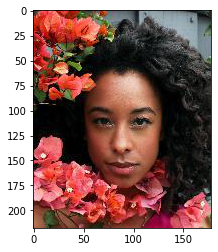

In [4]:
# check data contains images

celeba_dataset.plot_image(43)

# Helper Functions

In [5]:
# functions to generate random data

def generate_random_image(*size):
    random_data = mindspore.Tensor(numpy.random.rand(*size), mindspore.float32)
    return random_data


def generate_random_seed(*size):
    random_data = mindspore.Tensor(numpy.random.randn(*size), mindspore.float32)
    return random_data

In [6]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Cell):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def construct(self, x):
        return x.view(*self.shape)


## Discriminator Network

In [7]:
# discriminator class

class Discriminator(nn.Cell):
    
    def __init__(self):
        # initialise parent cell class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            View((-1, 218*178*3)),
            
            nn.Dense(3*218*178, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm((100,)),
            
            nn.Dense(100, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss(reduction='mean')

        # create optimizer
        self.optimizer = nn.Adam(self.model.trainable_params(), learning_rate=0.0001)
        
        self.model_with_loss = nn.WithLossCell(self.model, self.loss_function)
        self.model_train = nn.TrainOneStepCell(self.model_with_loss, self.optimizer)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
    
    def construct(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        # train one step
        loss = self.model_train(inputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.asnumpy().item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


## Test Discriminator

In [8]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()

label_true = mindspore.Tensor([[1.0]], mindspore.float32)
label_false = mindspore.Tensor([[0.0]], mindspore.float32)

for image_data_tensor in train_dataset:
    image_data_tensor = mindspore.ops.Stack()(image_data_tensor)
    # real data
    D.train(image_data_tensor, label_true)
    # fake data
    D.train(generate_random_image(218,178,3), label_false)


counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 6min 13s, sys: 3min 6s, total: 9min 19s
Wall time: 6min 32s


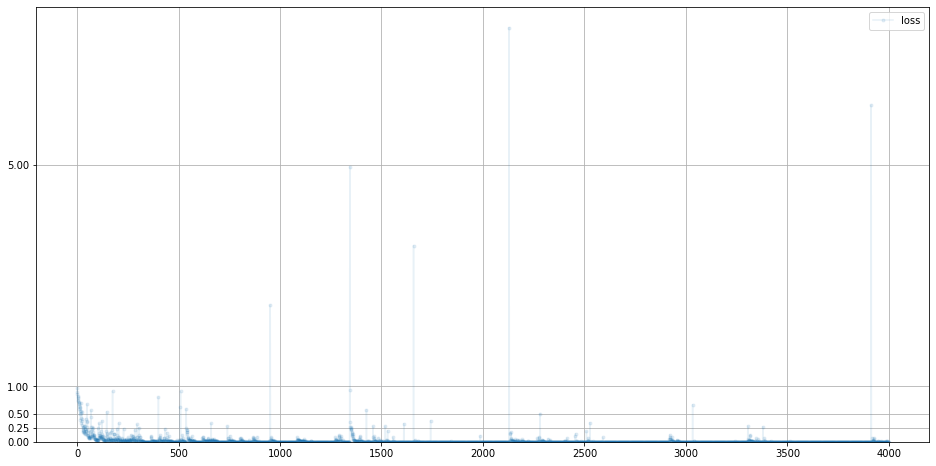

In [9]:
# plot discriminator loss

D.plot_progress()

In [10]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = mindspore.Tensor(celeba_dataset[random.randint(0,20000)][0], mindspore.float32)
  print( D.construct( image_data_tensor )[0].asnumpy().item() )

for i in range(4):
  print( D.construct( generate_random_image(218,178,3))[0].asnumpy().item() )


0.9998387098312378
0.9915143251419067
0.9997866749763489
0.9678099751472473
0.0008728535030968487
0.0010097951162606478
0.001106858137063682
0.0012609029654413462


## Generator Network

In [11]:
# generator class

class Generator(nn.Cell):
    
    def __init__(self, D_with_loss):
        # initialise parent cell class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            nn.Dense(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm((3*10*10,)),
            
            nn.Dense(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((-1, 218,178,3))
        )
        
        self.loss_fn = D_with_loss
        
        # create optimiser, simple stochastic gradient descent
        self.optimizer = nn.Adam(self.model.trainable_params(), learning_rate=0.0001)
        
        self.model_train = mindspore.build_train_network(self.model, self.optimizer, loss_fn=self.loss_fn)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = [] 
    
    def construct(self, inputs):        
        # simply run model
        if inputs.ndim == 1:
            inputs = mindspore.ops.ExpandDims()(inputs, 0)
            return self.model(inputs).squeeze(0)
        else:    
            return self.model(inputs)
    
    def train(self, inputs, targets):
        # train one step
        loss = self.model_train(inputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.asnumpy().item())

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


## Test Generator Output

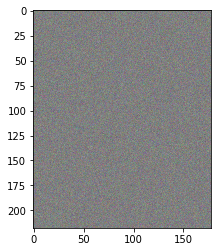

In [12]:
# check the generator output is of the right type and shape

D = Discriminator()
G = Generator(D.model_with_loss)

output = G.construct(generate_random_seed(100))

img = output.asnumpy()

plt.imshow(img, interpolation='none', cmap='Blues')

## Train GAN

In [13]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator(D.model_with_loss)

label_true = mindspore.Tensor([[1.0]], mindspore.float32)
label_false = mindspore.Tensor([[0.0]], mindspore.float32)

epochs = 2

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for image_data_tensor in train_dataset:
    image_data_tensor = mindspore.ops.Stack()(image_data_tensor)

    # train discriminator on true
    D.train(image_data_tensor, label_true)
    
    # train discriminator on false
    D.train(G.construct(generate_random_seed(1, 100)), label_false)
    
    # train generator
    G.train(generate_random_seed(1, 100), label_true)


epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

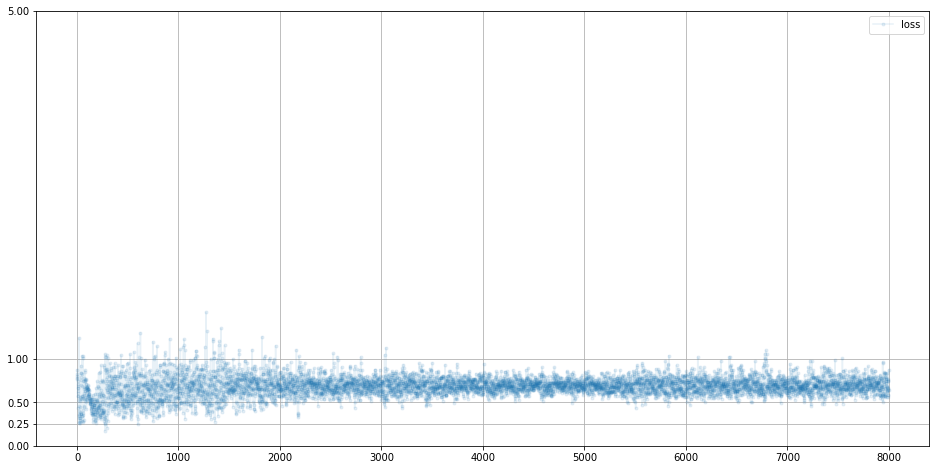

In [14]:
# plot discriminator error

D.plot_progress()

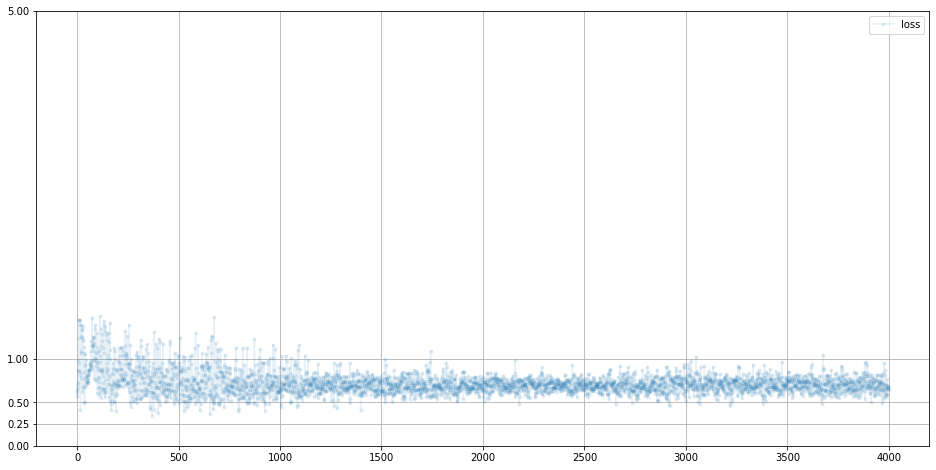

In [15]:
# plot generator error

G.plot_progress()

## Run Generator

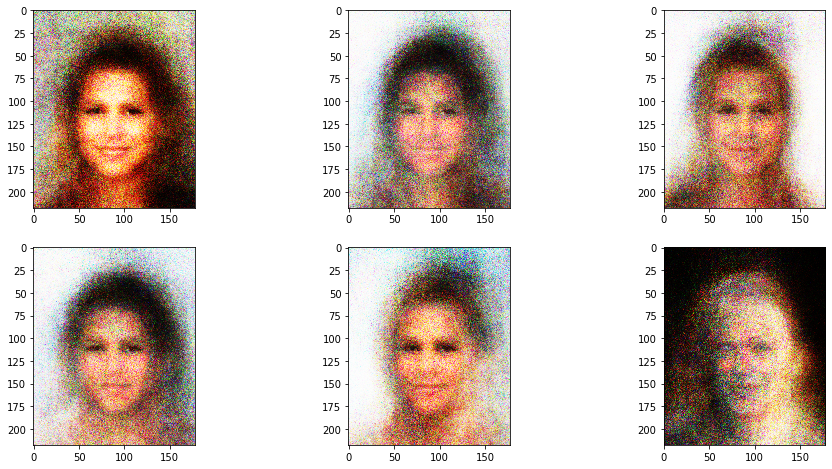

In [16]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.construct(generate_random_seed(100))
        img = output.asnumpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
